## Read data  

In [1]:
import pandas as pd
import numpy as np

In [2]:
path1 = r'C:\Users\hahas\Desktop\Marketing Analytics\Final Case\customer_service_reps'
path2 = r'C:\Users\hahas\Desktop\Marketing Analytics\Final Case\engagement'
path3 = r'C:\Users\hahas\Desktop\Marketing Analytics\Final Case\subscribers'
path4 = r'C:\Users\hahas\Desktop\Marketing Analytics\Final Case\advertising_spend_data.xlsx'

customer = pd.read_pickle(path1)
engagement = pd.read_pickle(path2)
subscribers = pd.read_pickle(path3)
ads = pd.read_excel(path4, skiprows=2)

In [3]:
customer.billing_channel.value_counts()

OTT       1848663
itunes     301713
google      58267
Name: billing_channel, dtype: int64

## Trial churn prediction model
#### Churn: Those who are not converted to paid subscription (the refund is taken into consideration) 

### Data preprocessing: 'engagement' data

In [4]:
engagement.head()

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0


In [5]:
engagement.columns

Index(['subid', 'date', 'app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started', 'payment_period'],
      dtype='object')

In [6]:
engagement.subid.nunique()

135019

In [8]:
# We only look at engagement activity during trial periods
engagement_modelling = engagement[engagement.payment_period==0]

In [9]:
# Trials periond ==0, now we have 134,992 users
engagement_modelling.subid.nunique()

134992

In [10]:
#creating aggregate metrics from transactions
df=engagement_modelling.groupby(['subid']).agg(
    
    sum_app_opens = ('app_opens','sum'),
    sum_cust_service_mssgs = ('cust_service_mssgs','sum'),
    sum_num_videos_completed = ('num_videos_completed', 'sum'),
    sum_num_videos_more_than_30_seconds = ('num_videos_more_than_30_seconds','sum'),
    sum_num_videos_rated = ('num_videos_rated','sum'),
    sum_num_series_started = ('num_series_started','sum'),
    
    active_days=('date','nunique'),
    max_day=('date','max'),
    min_day=('date','min'),

    avg_app_opens = ('app_opens','mean'),
    avg_cust_service_mssgs = ('cust_service_mssgs','mean'),
    avg_num_videos_completed = ('num_videos_completed','mean'),
    avg_num_videos_more_than_30_seconds = ('num_videos_more_than_30_seconds','mean'),
    avg_num_videos_rated = ('num_videos_rated','mean'),
    avg_num_series_started = ('num_series_started','mean')).reset_index()

df['duration']=(df.max_day-df.min_day).dt.days+1
df['active_per_dur'] = df.active_days/df.duration
df['app_opens_per_duration']=df.sum_app_opens/df.active_days
df['cust_service_mssgs_per_duration']=df.sum_cust_service_mssgs/df.duration
df['num_videos_completed_per_duration']=df.sum_num_videos_completed/df.duration
df['num_videos_more_than_30_seconds_per_duration']=df.sum_num_videos_more_than_30_seconds/df.active_days
df['num_videos_rated_per_duration']=df.sum_num_videos_rated/df.duration
df['num_series_started_per_duration']=df.sum_num_series_started/df.duration

engagement_agg=df.copy()

In [11]:
engagement_agg.head()

,subid,sum_app_opens,sum_cust_service_mssgs,sum_num_videos_completed,sum_num_videos_more_than_30_seconds,sum_num_videos_rated,sum_num_series_started,active_days,max_day,min_day,...,avg_num_videos_rated,avg_num_series_started,duration,active_per_dur,app_opens_per_duration,cust_service_mssgs_per_duration,num_videos_completed_per_duration,num_videos_more_than_30_seconds_per_duration,num_videos_rated_per_duration,num_series_started_per_duration
0,20000062,4.0,3.0,6.0,23.0,0.0,1.0,4,2019-07-04,2019-06-30,...,0.0,0.250000,5,0.800000,1.000000,0.600000,1.200000,5.750000,0.0,0.200000
1,20000405,5.0,4.0,13.0,17.0,0.0,1.0,4,2020-03-18,2020-03-08,...,0.0,0.250000,11,0.363636,1.250000,0.363636,1.181818,4.250000,0.0,0.090909
2,20000604,13.0,4.0,8.0,64.0,0.0,1.0,13,2020-02-23,2020-02-09,...,0.0,0.076923,15,0.866667,1.000000,0.266667,0.533333,4.923077,0.0,0.066667
3,20000685,17.0,4.0,11.0,63.0,0.0,7.0,13,2020-03-17,2020-03-03,...,0.0,0.538462,15,0.866667,1.307692,0.266667,0.733333,4.846154,0.0,0.466667
4,20000741,1.0,1.0,2.0,7.0,0.0,0.0,2,2019-08-26,2019-08-25,...,0.0,0.000000,2,1.000000,0.500000,0.500000,1.000000,3.500000,0.0,0.000000


In [12]:
engagement_agg.columns

Index(['subid', 'sum_app_opens', 'sum_cust_service_mssgs',
       'sum_num_videos_completed', 'sum_num_videos_more_than_30_seconds',
       'sum_num_videos_rated', 'sum_num_series_started', 'active_days',
       'max_day', 'min_day', 'avg_app_opens', 'avg_cust_service_mssgs',
       'avg_num_videos_completed', 'avg_num_videos_more_than_30_seconds',
       'avg_num_videos_rated', 'avg_num_series_started', 'duration',
       'active_per_dur', 'app_opens_per_duration',
       'cust_service_mssgs_per_duration', 'num_videos_completed_per_duration',
       'num_videos_more_than_30_seconds_per_duration',
       'num_videos_rated_per_duration', 'num_series_started_per_duration'],
      dtype='object')

In [13]:
# Take some important values
engagement_test = engagement_agg[['subid','active_days','duration',
       'max_day', 'min_day', 'active_per_dur',
       'app_opens_per_duration', 'cust_service_mssgs_per_duration',
       'num_videos_completed_per_duration',
       'num_videos_more_than_30_seconds_per_duration',
       'num_videos_rated_per_duration', 'num_series_started_per_duration']]

In [14]:
engagement_test.head()

,subid,active_days,duration,max_day,min_day,active_per_dur,app_opens_per_duration,cust_service_mssgs_per_duration,num_videos_completed_per_duration,num_videos_more_than_30_seconds_per_duration,num_videos_rated_per_duration,num_series_started_per_duration
0,20000062,4,5,2019-07-04,2019-06-30,0.800000,1.000000,0.600000,1.200000,5.750000,0.0,0.200000
1,20000405,4,11,2020-03-18,2020-03-08,0.363636,1.250000,0.363636,1.181818,4.250000,0.0,0.090909
2,20000604,13,15,2020-02-23,2020-02-09,0.866667,1.000000,0.266667,0.533333,4.923077,0.0,0.066667
3,20000685,13,15,2020-03-17,2020-03-03,0.866667,1.307692,0.266667,0.733333,4.846154,0.0,0.466667
4,20000741,2,2,2019-08-26,2019-08-25,1.000000,0.500000,0.500000,1.000000,3.500000,0.0,0.000000


### Data preprocessing: 'subscribers' data

In [15]:
subscribers_modelling = subscribers[subscribers.subid.isin(engagement.subid)]

In [16]:
subscribers_modelling.shape

(135019, 29)

In [17]:
# Drop columns with missing value more than 20%
drop_TF = subscribers_modelling.isnull().sum() / len(subscribers_modelling) * 100 < 17

In [18]:
subscribers_modelling = subscribers_modelling.loc[:,drop_TF]

In [19]:
subscribers_modelling.isnull().sum() / len(subscribers_modelling) * 100

subid                            0.000000
intended_use                     1.519786
retarget_TF                      0.000000
age                             16.818374
male_TF                          0.000000
country                          0.000000
attribution_technical            0.000000
attribution_survey               1.179093
op_sys                           0.003703
months_per_bill_period           0.000000
plan_type                        0.000000
monthly_price                    0.000000
discount_price                   0.000000
account_creation_date            0.000000
cancel_before_trial_end          0.000000
trial_end_date                   0.000000
initial_credit_card_declined     0.000000
revenue_net                     16.818374
join_fee                        16.818374
language                         0.000000
paid_TF                          0.000000
refund_after_trial_TF            0.000000
dtype: float64

In [20]:
# Drop unnecessary columns
# 'attribution_survey': we only use attribution_technical
# 'months_per_bill_period', 'language': only one value
# 'monthly_price': we have discounted_price

subscribers_modelling = subscribers_modelling.drop(columns=['attribution_survey',
                                                            'months_per_bill_period',
                                                           'monthly_price','language','age' ])

In [21]:
# Missing value imputation - categorical variables
columns=['intended_use','op_sys']
for c in columns:
    notnull = len(subscribers_modelling) - subscribers_modelling[c].isnull().sum()
    category_fill= np.random.choice((list(subscribers_modelling[pd.isnull(subscribers_modelling[c])==False][c].unique())),size = subscribers_modelling[c].isnull().sum(),
                                      p=list(subscribers_modelling[c].value_counts()/notnull))
    subscribers_modelling.loc[subscribers_modelling[c].isnull(),c] = category_fill

In [22]:
subscribers_modelling.columns

Index(['subid', 'intended_use', 'retarget_TF', 'male_TF', 'country',
       'attribution_technical', 'op_sys', 'plan_type', 'discount_price',
       'account_creation_date', 'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'paid_TF',
       'refund_after_trial_TF'],
      dtype='object')

In [23]:
# Selecting columns from subscribers dataset

# 1) do not know until trial ends: time frame does not match - need to drop
# 'initial_credit_card_declined' - drop
# 'discount_price' - keep for LTV

# 2) 'paid_TF', 'refund_after_trial_TF': keep for y variable

# 3) 'trial_end_date': keep for data validation

subscribers_modelling = subscribers_modelling.drop(columns=['initial_credit_card_declined'])

### Data preprocessing: 'customer' data

In [24]:
customer_modelling = customer[customer.subid.isin(engagement.subid)]

In [25]:
# customer datasets is only used for data validation (won't be used for traning the model)
customer_modelling = customer_modelling[['subid','trial_completed_TF','num_trial_days']]

In [26]:
# Merge 'customer' data and 'subscribers' data
data_for_validation = pd.merge(customer_modelling, subscribers_modelling, on='subid')

In [27]:
# confirmed that 'trial_completed_TF' and 'cancel_before_trial_end' match: Test OK
data_for_validation.groupby('trial_completed_TF').cancel_before_trial_end.value_counts()

trial_completed_TF  cancel_before_trial_end
False               False                       72645
True                True                       137214
Name: cancel_before_trial_end, dtype: int64

In [28]:
# Users who completed trial but 0 number of trial days exist: 83 people
data_for_validation.groupby('trial_completed_TF').num_trial_days.value_counts()

trial_completed_TF  num_trial_days
False               14                 72645
True                14                137131
                    0                     83
Name: num_trial_days, dtype: int64

### Merging preprocessed data (subscribers + engagement)

In [29]:
data_merged = pd.merge(subscribers_modelling, engagement_test, on='subid')

In [30]:
data_merged.columns

Index(['subid', 'intended_use', 'retarget_TF', 'male_TF', 'country',
       'attribution_technical', 'op_sys', 'plan_type', 'discount_price',
       'account_creation_date', 'cancel_before_trial_end', 'trial_end_date',
       'revenue_net', 'join_fee', 'paid_TF', 'refund_after_trial_TF',
       'active_days', 'duration', 'max_day', 'min_day', 'active_per_dur',
       'app_opens_per_duration', 'cust_service_mssgs_per_duration',
       'num_videos_completed_per_duration',
       'num_videos_more_than_30_seconds_per_duration',
       'num_videos_rated_per_duration', 'num_series_started_per_duration'],
      dtype='object')

In [31]:
# Check if there is any engagement record after trial ended -> no record: Test OK
condition = data_merged.max_day > data_merged.trial_end_date
data_merged[condition]

,subid,intended_use,retarget_TF,male_TF,country,attribution_technical,op_sys,plan_type,discount_price,account_creation_date,...,duration,max_day,min_day,active_per_dur,app_opens_per_duration,cust_service_mssgs_per_duration,num_videos_completed_per_duration,num_videos_more_than_30_seconds_per_duration,num_videos_rated_per_duration,num_series_started_per_duration


In [32]:
data_merged.groupby('cancel_before_trial_end').paid_TF.value_counts() # TF was flipped here

cancel_before_trial_end  paid_TF
False                    False      72645
True                     True       57456
                         False       4891
Name: paid_TF, dtype: int64

In [33]:
data_merged[data_merged.paid_TF==True].refund_after_trial_TF.value_counts()

False    53148
True      4308
Name: refund_after_trial_TF, dtype: int64

### identify 'churn' 

In [34]:
# Check users who converted to paid subscription and later requested refund
condition2 = (data_merged.paid_TF==True) & (data_merged.refund_after_trial_TF==True)
data_y_test = data_merged[condition2]
print("Users who have null value: " + str(data_y_test.revenue_net.isnull().sum()))
print("Users who have negative net revenue: "+ str(data_y_test[data_y_test.revenue_net <= 0].subid.nunique()))
print("Users who have positive net revenue: "+str(data_y_test[data_y_test.revenue_net > 0].subid.nunique()))

Users who have null value: 923
Users who have negative net revenue: 3123
Users who have positive net revenue: 262


In [35]:
# Check users who converted to paid subscription and did not request refund
condition3 = (data_merged.paid_TF==True) & (data_merged.refund_after_trial_TF==False)
data_y_test2 = data_merged[condition3]
print("Users who have null value: " +str(data_y_test2.revenue_net.isnull().sum()))
print("Users who have negative net revenue: "+ str(data_y_test2[data_y_test2.revenue_net <= 0].subid.nunique()))
print("Users who have positive net revenue: "+str(data_y_test2[data_y_test2.revenue_net > 0].subid.nunique()))

Users who have null value: 21785
Users who have negative net revenue: 304
Users who have positive net revenue: 31059


In [36]:
data_merged.columns

Index(['subid', 'intended_use', 'retarget_TF', 'male_TF', 'country',
       'attribution_technical', 'op_sys', 'plan_type', 'discount_price',
       'account_creation_date', 'cancel_before_trial_end', 'trial_end_date',
       'revenue_net', 'join_fee', 'paid_TF', 'refund_after_trial_TF',
       'active_days', 'duration', 'max_day', 'min_day', 'active_per_dur',
       'app_opens_per_duration', 'cust_service_mssgs_per_duration',
       'num_videos_completed_per_duration',
       'num_videos_more_than_30_seconds_per_duration',
       'num_videos_rated_per_duration', 'num_series_started_per_duration'],
      dtype='object')

In [ ]:
# 1) Not churn (53,148 users)
# 'paid_TF == True' & 'refund_after_trial_TF==False'

# 2) Churn (81,844 users)
# 'paid_TF == False': churn (4,891)
# 'paid_TF == True' & 'refund_after_trial_TF==True' : churn (4,308)
# 'cancel_before_trial_ends== True' : churn (72,645)

### Add 'Churn' column: either 0 or 1

In [37]:
not_churn = (data_merged.paid_TF == True) & (data_merged.refund_after_trial_TF==False)

In [38]:
def define_y(row):
    if (row['paid_TF']== True) & (row['refund_after_trial_TF']==False):
        return 0
    else:
        return 1
    
data_merged['churn'] = data_merged.apply(lambda row: define_y(row), axis=1)

In [39]:
data_merged['churn'].value_counts()

1    81844
0    53148
Name: churn, dtype: int64

### Prepare traning dataset 

In [40]:
num=['active_per_dur','app_opens_per_duration',
       'cust_service_mssgs_per_duration', 'num_videos_completed_per_duration',
       'num_videos_more_than_30_seconds_per_duration',
       'num_videos_rated_per_duration', 'num_series_started_per_duration']

cat=['intended_use','male_TF','attribution_technical', 'op_sys', 'plan_type']

X_num = data_merged[num]
X_cat = data_merged[cat]

# Creating dummy variable dataframe from categorical variables.
X_data = X_num.join(pd.get_dummies(X_cat))

In [41]:
# train-test data split
from sklearn.model_selection import train_test_split
X = X_data
y = data_merged['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state = 0)

In [42]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train[num])
X_test_scale = scaler.transform(X_test[num])

In [43]:
# reflects scaled data
X_train.loc[:,num]= X_train_scale
X_test.loc[:,num] = X_test_scale

C:\Users\hahas\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Important Features with logistic regression 

In [44]:
# feature selection - logistic
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
rfe = RFE(model, 10)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 10
Selected Features: [False  True  True  True  True  True  True False False False False False
 False False False False False  True False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False  True False False False False False False]
Feature Ranking: [39  1  1  1  1  1  1 31 49 45 30 29 40 44  5 16 26  1 35 13 32 38 17 42
  1 43 14 28  7 27 22 48 10 12 46 33 20 25  3  8 23  4  6 21 24  1  2  9
 15 34 11  1 47 18 41 36 37 19]


In [45]:
X_train.columns[fit.support_]

Index(['app_opens_per_duration', 'cust_service_mssgs_per_duration',
       'num_videos_completed_per_duration',
       'num_videos_more_than_30_seconds_per_duration',
       'num_videos_rated_per_duration', 'num_series_started_per_duration',
       'attribution_technical_appstore', 'attribution_technical_direct_mail',
       'attribution_technical_tv', 'plan_type_base_eur_14_day_trial'],
      dtype='object')

In [46]:
cols=['active_per_dur', 'app_opens_per_duration',
       'cust_service_mssgs_per_duration', 'num_videos_completed_per_duration',
       'num_videos_more_than_30_seconds_per_duration',
       'num_videos_rated_per_duration', 'num_series_started_per_duration',
     'attribution_technical_pinterest_organic', 'op_sys_Android',
       'op_sys_iOS']

In [47]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train[cols])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.525678
         Iterations 8
                                         Results: Logit
Model:                         Logit                      Pseudo R-squared:           0.216     
Dependent Variable:            churn                      AIC:                        85174.5218
Date:                          2020-05-16 23:16           BIC:                        85267.5433
No. Observations:              80995                      Log-Likelihood:             -42577.   
Df Model:                      9                          LL-Null:                    -54298.   
Df Residuals:                  80985                      LLR p-value:                0.0000    
Converged:                     1.0000                     Scale:                      1.0000    
No. Iterations:                8.0000                                                           
------------------------------------------------------------------

In [50]:
# Build the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score 

clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(cnf_matrix)
print('Accuracy: %f' % metrics.accuracy_score(y_test,y_pred))
print('Recall: %f' % (metrics.recall_score(y_test,y_pred)))
print('Precision: %f' % (metrics.precision_score(y_test,y_pred)))
print('F1 Score: %f' % (metrics.f1_score(y_test,y_pred)))
print('AUC: %f' % roc_auc)
#print('Coefficient of each feature:', clf.coef_)

[[12998  8259]
 [ 5691 27049]]
Accuracy: 0.741652
Recall: 0.826176
Precision: 0.766087
F1 Score: 0.794998
AUC: 0.798876


## Important Features with Random Forest

In [51]:
# Build the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score 
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(bootstrap= True, class_weight=None, random_state=0)

RF.fit(X_train, y_train)
pred_RF = RF.predict(X_test)
prob_RF = RF.predict_proba(X_test)[:, 1]

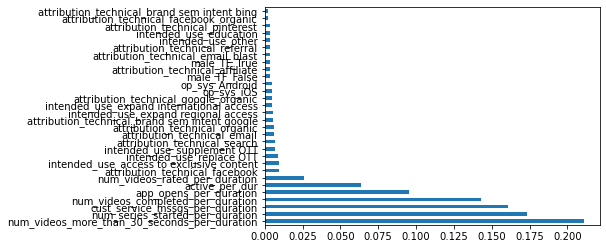

In [52]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(RF.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [53]:
print(confusion_matrix(y_test,pred_RF))
print(classification_report(y_test,pred_RF))
print(accuracy_score(y_test, pred_RF))

[[15949  5308]
 [ 2925 29815]]
              precision    recall  f1-score   support

           0       0.85      0.75      0.79     21257
           1       0.85      0.91      0.88     32740

    accuracy                           0.85     53997
   macro avg       0.85      0.83      0.84     53997
weighted avg       0.85      0.85      0.85     53997

0.8475285664018372


### Selected features from two models - mostly related to engagement activities

In [114]:
rf_mask = RF.feature_importances_
lr_mask = fit.support_
votes = np.sum([lr_mask, rf_mask], axis=0)

In [55]:
feat_importances = pd.Series(votes, index=X_train.columns)
feat_importances.nlargest(15)

num_videos_more_than_30_seconds_per_duration    1.210662
num_series_started_per_duration                 1.173441
cust_service_mssgs_per_duration                 1.160872
num_videos_completed_per_duration               1.143028
app_opens_per_duration                          1.095537
num_videos_rated_per_duration                   1.025977
attribution_technical_direct_mail               1.000297
attribution_technical_appstore                  1.000068
plan_type_base_eur_14_day_trial                 1.000055
attribution_technical_tv                        1.000017
active_per_dur                                  0.063589
attribution_technical_facebook                  0.009340
intended_use_access to exclusive content        0.009205
intended_use_replace OTT                        0.008694
intended_use_supplement OTT                     0.006849
dtype: float64

In [56]:
selected_features = feat_importances.nlargest(15).index

In [57]:
selected_features

Index(['num_videos_more_than_30_seconds_per_duration',
       'num_series_started_per_duration', 'cust_service_mssgs_per_duration',
       'num_videos_completed_per_duration', 'app_opens_per_duration',
       'num_videos_rated_per_duration', 'attribution_technical_direct_mail',
       'attribution_technical_appstore', 'plan_type_base_eur_14_day_trial',
       'attribution_technical_tv', 'active_per_dur',
       'attribution_technical_facebook',
       'intended_use_access to exclusive content', 'intended_use_replace OTT',
       'intended_use_supplement OTT'],
      dtype='object')

## Hyperparameter Tuning with logistic regression

### Validation Curve with C (metric: accuracy)

C:\Users\hahas\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\hahas\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


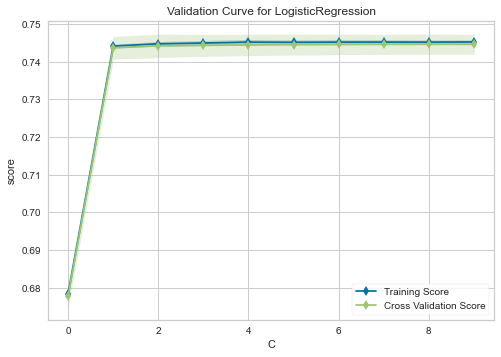

In [59]:
# Plotting
from yellowbrick.model_selection import ValidationCurve
param_range = np.arange(0.001,10) 

viz =ValidationCurve(
    LogisticRegression(solver='liblinear'), param_name= 'C', param_range=param_range, cv=5, scoring="accuracy")

viz.fit(X_train, y_train)
viz.show()

### Validation Curve with C (metric: AUC score) 

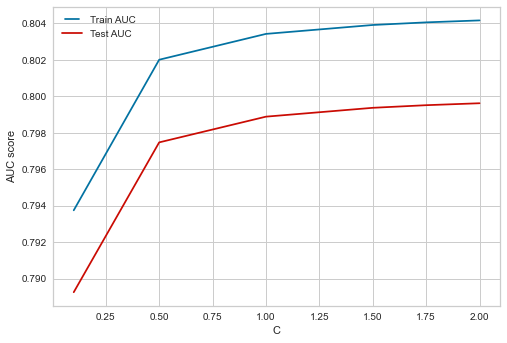

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, auc

C = [0.1, 0.5, 1, 1.5, 1.75, 2]
train_results = []
test_results = []
for c in C:
    model = LogisticRegression(C=c,solver='liblinear',random_state = 0)
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(C, train_results, "b", label="Train AUC")
line2, = plt.plot(C, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("C")
plt.show()

### Grid Search - logistic regression

In [115]:
# from sklearn.model_selection import GridSearchCV
import time

C = np.linspace(0.8, 2.0, num=10)
max_iter = np.arange(100,150,10)
param_grid = dict(max_iter = max_iter, C=C)

grid = GridSearchCV(estimator = LogisticRegression(solver='liblinear'), param_grid = param_grid, cv=5, n_jobs=-1)
grid_result = grid.fit(X_train,y_train)
start_time = time.time()

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.744231 using {'C': 2.0, 'max_iter': 100}
Execution time: 0.0020673274993896484 ms


## Final Model - logistic regression

[[12949  8308]
 [ 5626 27114]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65     21257
           1       0.77      0.83      0.80     32740

    accuracy                           0.74     53997
   macro avg       0.73      0.72      0.72     53997
weighted avg       0.74      0.74      0.74     53997

Test accuracy:0.74
Training accuracy: 0.7447002901413667


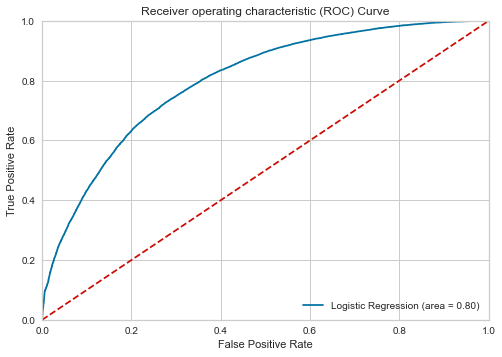

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

#logmodel = LogisticRegression(C= 2.0, max_iter= 100, solver='liblinear')
#logmodel.fit(X_train,y_train)
pred_log = grid_result.predict(X_test)
prob_log = grid_result.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test,pred_log))
print(classification_report(y_test,pred_log))
print('Test accuracy:{:.2f}'.format(logmodel.score(X_test, y_test)))
print('Training accuracy:', logmodel.score(X_train, y_train))
#print('Coefficient of each feature:', logmodel.coef_)

roc_value = roc_auc_score(y_test, prob_log)
fpr, tpr, thresholds = roc_curve(y_test,prob_log)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_value)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Build up random forest model

In [63]:
pred_RF = RF.predict(X_test)
prob_RF = RF.predict_proba(X_test)[:, 1]

In [64]:
print(confusion_matrix(y_test,pred_RF))
print(classification_report(y_test,pred_RF))
print(accuracy_score(y_test, pred_RF))

[[15949  5308]
 [ 2925 29815]]
              precision    recall  f1-score   support

           0       0.85      0.75      0.79     21257
           1       0.85      0.91      0.88     32740

    accuracy                           0.85     53997
   macro avg       0.85      0.83      0.84     53997
weighted avg       0.85      0.85      0.85     53997

0.8475285664018372


## Hyperparameter Tuning with Random Forest

### Validation Curve with max_depth (metric: AUC) 

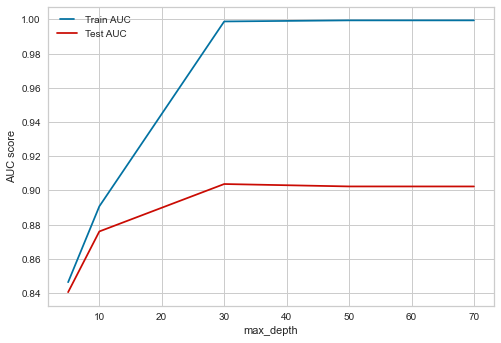

In [117]:
# max_depth
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

max_depth = [5,10,30,50,70]
train_results = []
test_results = []
for max_d in max_depth:
   model = RandomForestClassifier(bootstrap=True,max_depth=max_d, random_state=0)
   model.fit(X_train, y_train)
   train_pred = model.predict_proba(X_train)[:,1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict_proba(X_test)[:,1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depth, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max_depth")
plt.show()

### Validation Curve with n_estimators (metric: AUC)

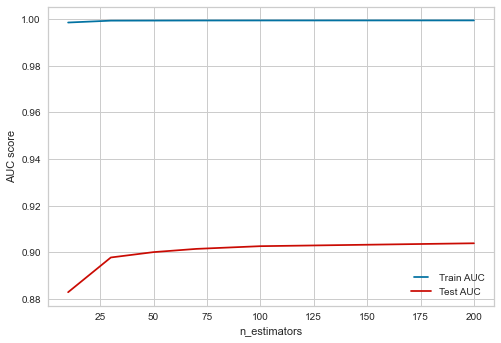

In [66]:
# number of trees
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

n_estimators = [10,30,50,70,100,200]
train_results = []
test_results = []
for n_estimator in n_estimators:
   model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                  n_estimators=n_estimator, random_state=0)
   model.fit(X_train, y_train)
   train_pred = model.predict_proba(X_train)[:,1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict_proba(X_test)[:,1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Grid search - Random Forest

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth' : list(range(20,31,10)), #10
    'max_features' : list(range(5,30,10)), #10
}

grid = GridSearchCV(RandomForestClassifier(bootstrap = True, n_estimators = 100), param_grid, cv=5)

[[15949  5308]
 [ 2925 29815]]
              precision    recall  f1-score   support

           0       0.85      0.75      0.79     21257
           1       0.85      0.91      0.88     32740

    accuracy                           0.85     53997
   macro avg       0.85      0.83      0.84     53997
weighted avg       0.85      0.85      0.85     53997

0.8475285664018372


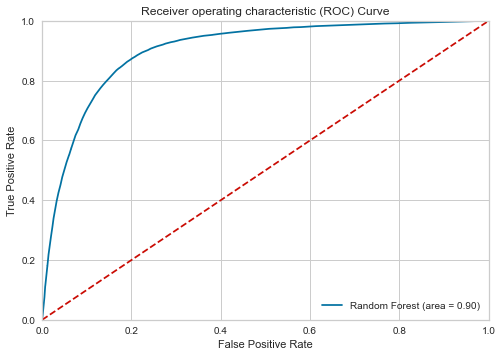

In [68]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Build the model
y_pred_RF = RF.predict(X_test)
y_prob_RF = RF.predict_proba(X_test)[:, 1]
print(confusion_matrix(y_test,y_pred_RF))
print(classification_report(y_test,y_pred_RF))
print(accuracy_score(y_test, y_pred_RF))

roc_value = roc_auc_score(y_test,y_prob_RF)
fpr, tpr, threshold = roc_curve(y_test,y_prob_RF)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_value)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Final model - Random Forest

In [69]:
best_RF = grid.fit(X_train, y_train)
best_RF.best_params_
best_RF.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[[16591  4666]
 [ 2934 29806]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     21257
           1       0.86      0.91      0.89     32740

    accuracy                           0.86     53997
   macro avg       0.86      0.85      0.85     53997
weighted avg       0.86      0.86      0.86     53997

0.859251439894809


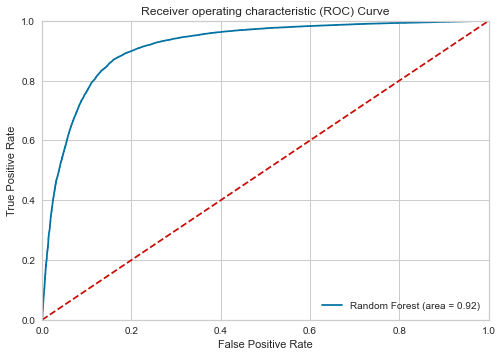

In [70]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Build the model
y_pred_RF = best_RF.predict(X_test)
y_prob_RF = best_RF.predict_proba(X_test)[:, 1]
print(confusion_matrix(y_test,y_pred_RF))
print(classification_report(y_test,y_pred_RF))
print(accuracy_score(y_test, y_pred_RF))

roc_value = roc_auc_score(y_test,y_prob_RF)
fpr, tpr, threshold = roc_curve(y_test,y_prob_RF)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_value)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Applications of Churn modelling

### Takeaway1. Revenue modelling - senario planning on giving discount offer to possible churners 

In [71]:
# Getting predictions on test_dataset
pred_mkt = pd.DataFrame()
pred_mkt['churn'] = y_test
pred_mkt['prob']=y_prob_RF

In [87]:
pred_mkt.to_csv('pred_mkt.csv',index=False)

### Takeaway2. A distribution of expected CLV

In [73]:
# Read pre-calculated CAC Table 
CAC_by_tier_by_channel = pd.read_csv('CAC_by_tier_by_channel.csv')

In [75]:
# Drop mean
CAC_by_tier_by_channel = CAC_by_tier_by_channel[:-1]

In [76]:
# Create 'tier' column per customer

# from datetime import datetime, timedelta
def assign_tier(row):
    if row.account_creation_date <= pd.Timestamp(2019,7,30):
        return 0
    if (row.account_creation_date > pd.Timestamp(2019,7,30)) & (row.account_creation_date <= pd.Timestamp(2019,8,30)):
        return 1
    if (row.account_creation_date > pd.Timestamp(2019,8,30)) & (row.account_creation_date <= pd.Timestamp(2019,9,30)):
        return 2
    if (row.account_creation_date > pd.Timestamp(2019,9,30)) & (row.account_creation_date <= pd.Timestamp(2019,10,30)):
        return 3
    if (row.account_creation_date > pd.Timestamp(2019,10,30)) & (row.account_creation_date <= pd.Timestamp(2019,11,30)):
        return 4
    if (row.account_creation_date > pd.Timestamp(2019,11,30)) & (row.account_creation_date <= pd.Timestamp(2019,12,30)):
        return 5
    if (row.account_creation_date > pd.Timestamp(2019,12,30)) & (row.account_creation_date <= pd.Timestamp(2020,1,30)):
        return 6
    if (row.account_creation_date > pd.Timestamp(2020,1,30)) & (row.account_creation_date <= pd.Timestamp(2020,2,29)):
        return 7
    if (row.account_creation_date > pd.Timestamp(2020,2,29)) & (row.account_creation_date <= pd.Timestamp(2020,3,30)):
        return 8

In [77]:
data_merged['tier'] = data_merged.apply(lambda row: assign_tier(row), axis=1)

In [78]:
data_merged.tier.value_counts()

0    22538
8    20229
4    18313
7    16751
5    13149
2    12592
1    11270
3    10276
6     9874
Name: tier, dtype: int64

###  Assign CAC to individuals

In [ ]:
# Assign 'unknown channels' to 'known channels'

# 1) youtube, podcast, twitter -> facebook
# 2) display, influencer, samsung, criteo-> affiliate
# 3) brand sem intent bing, bing -> brand sem intent google
# 4) 'organic', 'google_organic','facebook_organic','discovery','other','internal','bing_organic','direct_mail','pinterest_organic','quora','appstore','playstore','tv','content_greatist','ott','vod'-> organic

In [79]:
# Add CAC_i column to individuals

channels = ['facebook', 'email', 'search', 'brand sem intent google',
       'affiliate', 'email_blast', 'pinterest', 'referral']

def find_CAC_i(row):
    for i in list(range(0,9)):
        for channel in channels:
            if (row['tier']== i) & (row['attribution_technical'] == channel):
                return CAC_by_tier_by_channel.iloc[i][channel]
            if (row['tier']== i) & (row['attribution_technical'] in (['youtube','podcast','twitter'])):
                return CAC_by_tier_by_channel.iloc[i]['facebook']           
            if (row['tier']== i) & (row['attribution_technical'] in (['display','influencer','samsung','criteo'])):
                return CAC_by_tier_by_channel.iloc[i]['affiliate']
            if (row['tier']== i) & (row['attribution_technical'] in (['brand sem intent bing','bing'])):
                return CAC_by_tier_by_channel.iloc[i]['brand sem intent google']

In [80]:
data_merged['CAC_i']= data_merged.apply(lambda row: find_CAC_i(row), axis=1)

In [81]:
# giving CAC as 0 to organic channels
find = data_merged.attribution_technical.isin(['organic', 'google_organic','facebook_organic',
                                              'discovery','other','internal','bing_organic',
                                              'direct_mail','pinterest_organic','quora','appstore',
                                              'playstore','tv','content_greatist','ott','vod'])
data_merged.loc[find,'CAC_i'] = 0

In [82]:
# Check Null: Test OK
data_merged[data_merged.CAC_i.isnull()].attribution_technical.value_counts()

Series([], Name: attribution_technical, dtype: int64)

In [83]:
# Check data integrity: Test OK
data_merged[['tier','attribution_technical','CAC_i']]

,tier,attribution_technical,CAC_i
0,5,organic,0.000000
1,7,bing,1.161304
2,8,email,1.964951
3,7,facebook,0.757825
4,5,search,0.909116
...,...,...,...
134987,6,facebook,1.413145
134988,8,affiliate,0.836310
134989,6,email,5.545145
134990,4,facebook,0.463674


In [84]:
data_merged.groupby('plan_type').discount_price.value_counts()

plan_type              discount_price
base_eur_14_day_trial  4.2205                10
base_uae_14_day_trial  4.5141            134726
high_aud_14_day_trial  3.7801                 2
high_jpy_14_day_trial  4.4407                 1
high_sar_14_day_trial  4.0737                10
high_uae_14_day_trial  5.0279               242
low_gbp_14_day_trial   4.3673                 1
Name: discount_price, dtype: int64

In [85]:
# calcualte payment_i as mean discount price
payment_i = data_merged.discount_price.mean()
payment_i

4.514954209130191

In [86]:
# add probabilities of churn per customer
data_merged['prob_churn'] = pd.read_csv('pred_mkt.csv')['prob']

### Calculate CLV_i  

In [88]:
def calculate_clv(row, payment_i, discount):
    return (payment_i*(1+discount) / (1+discount-1+row.prob_churn))-row.CAC_i

In [110]:
# calculate CLV with discount rate 10%
data_merged['CLV_i'] = data_merged.apply(lambda row: calculate_clv(row,payment_i,0.10), axis=1)

In [111]:
# get mean CLV
data_merged['CLV_i'].mean()

4.664109370793693

In [91]:
# get median CLV
data_merged['CLV_i'].median()

4.473212066235845

In [92]:
# get min CLV
data_merged['CLV_i'].min()

-11.475567330141796

In [93]:
# get max CLV
data_merged['CLV_i'].max()

37.95093358423804

## A Distribution of expected CLV

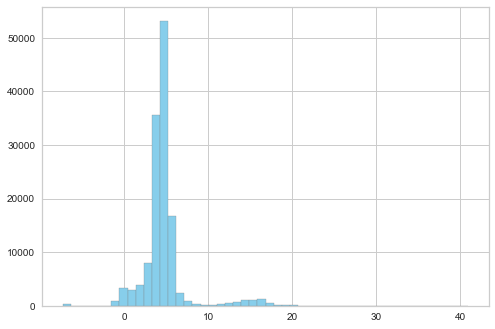

In [94]:
# Plot 1
plt.hist(data_merged['CLV_i'],facecolor='skyblue',
         edgecolor = 'gray', bins=50,
        range=(-7.36,41))
plt.show()

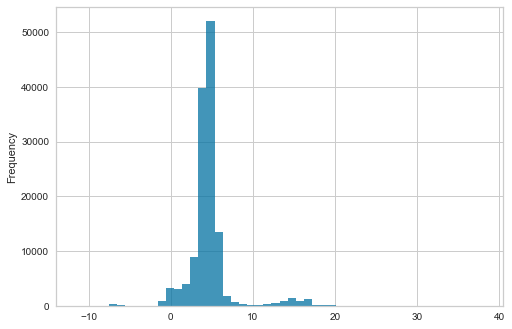

In [95]:
# Plot 2
data_merged['CLV_i'].plot(kind='hist', bins=50, alpha=0.75)

Text(0, 0.5, 'Density')

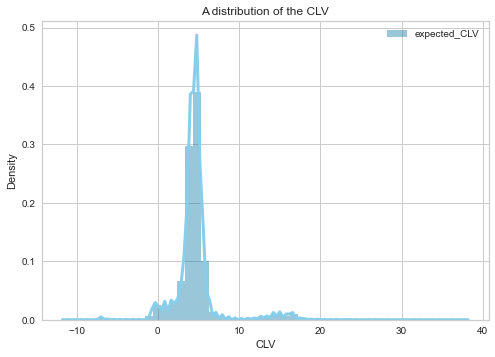

In [96]:
# Plot 3
import seaborn as sns
sns.distplot(data_merged['CLV_i'], hist = True, kde = True, label='expected_CLV',kde_kws={"color": "skyblue", "lw": 3})

# formatting
plt.legend(prop={'size': 10})
plt.title('A distribution of the CLV')
plt.xlabel('CLV')
plt.ylabel('Density')

## Comparison of CLV between groups

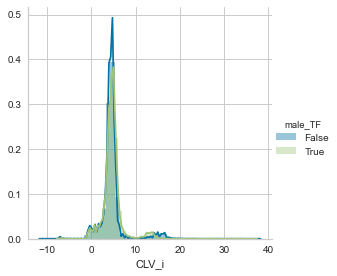

In [97]:
# Gender: no significant difference
sns.FacetGrid(data_merged, hue='male_TF',height=4).map(sns.distplot,"CLV_i").add_legend()

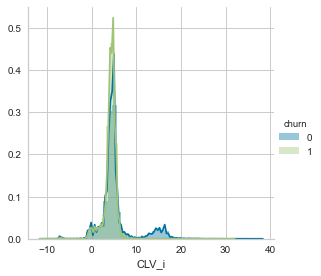

In [98]:
# shows different distribution
sns.FacetGrid(data_merged, hue='churn',height=4).map(sns.distplot,"CLV_i").add_legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A08DD8108>,
      dtype=object)

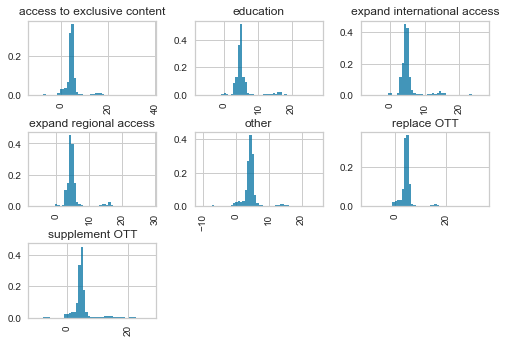

In [99]:
# intended use: exclusive, supplement OTT, replace OTT shows higher CLV
data_merged.hist(by='intended_use', column='CLV_i', bins=50, density=True, alpha=0.75)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A08DD0608>,
      dtype=object)

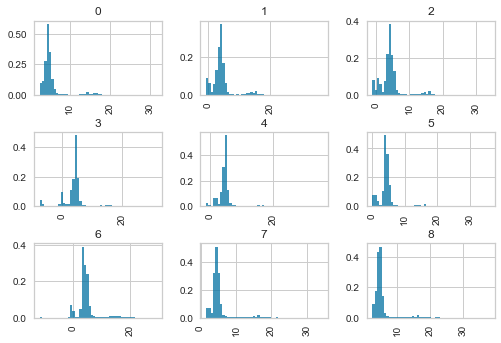

In [101]:
# Tier
data_merged.hist(by='tier', column='CLV_i', bins=50, density=True, alpha=0.75)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0D5A9B08>,
      dtype=object)

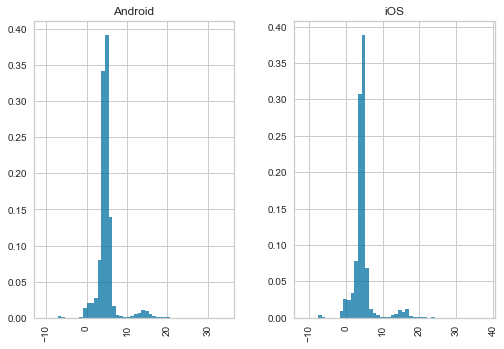

In [100]:
# no sig diff
data_merged.hist(by='op_sys', column='CLV_i', bins=50, density=True, alpha=0.75)

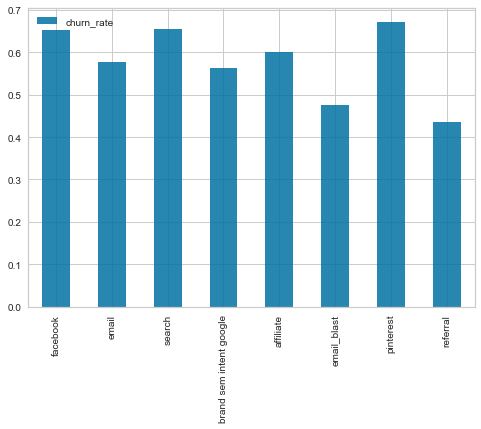

In [103]:
churn_rates=[]

for channel in channels:
    churn_rate = data_merged.groupby('attribution_technical').churn.sum()[channel] / data_merged.attribution_technical.value_counts()[channel]
    churn_rates.append(churn_rate)
churn_rates = pd.DataFrame(churn_rates, index=channels, columns=['churn_rate'])
churn_rates.plot(kind='bar',alpha=.85)
plt.show()

## Compare churn rates across channels

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

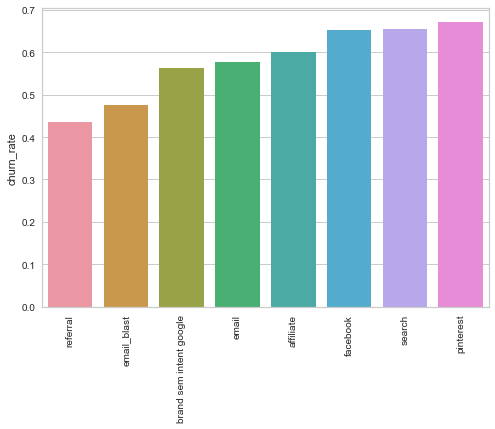

In [106]:
# plotting in order
sns.barplot(x=churn_rates.index,
            y="churn_rate", data=churn_rates,
            order=churn_rates.sort_values('churn_rate').index)
plt.xticks(rotation='vertical') 

In [107]:
# Churn rate table by channel
churn_rates.sort_values('churn_rate')

,churn_rate
referral,0.434871
email_blast,0.475167
brand sem intent google,0.562999
email,0.576949
affiliate,0.600360
facebook,0.651885
search,0.654565
pinterest,0.670926


## Compare churn rates between two groups

In [108]:
# Group 1 = 'email', 'affiliate', 'email_blast'

channels = ['email', 'affiliate', 'email_blast']
numerator_sum=0
denominator_sum = 0

for channel in channels:
    nume = data_merged.groupby('attribution_technical').churn.sum()[channel]
    deno = data_merged.attribution_technical.value_counts()[channel]
    numerator_sum = numerator_sum + nume
    denominator_sum = denominator_sum + deno

print(numerator_sum/denominator_sum)

0.5639525500322788


In [109]:
# Group 2 = 'facebook',  'search', 'brand sem intent google', 'pinterest', 'referral'

channels = ['facebook',  'search', 'brand sem intent google',
        'pinterest', 'referral']

numerator_sum=0
denominator_sum = 0

for channel in channels:
    nume = data_merged.groupby('attribution_technical').churn.sum()[channel]
    deno = data_merged.attribution_technical.value_counts()[channel]
    numerator_sum = numerator_sum + nume
    denominator_sum = denominator_sum + deno

print(numerator_sum/denominator_sum)

0.6319257113732705
